In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
view = 0
batch_sz = 4
epochs = 1
steps_per_epoch = 1000
validation_steps = 100

In [3]:
import os
import cv2
import shutil
import numpy as np
from pathlib import Path
from random import shuffle

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as keras

In [4]:
data_path = Path('/content/drive/MyDrive/DatasetUNet')

In [6]:
def split_raw_data(data_path, train_size = 0.7, val_size = 0.15,imgs_dir_name= 'images', labels_dir_name= 'labels'):
    images_path = os.path.join(data_path, imgs_dir_name)
    labels_path = os.path.join(data_path, labels_dir_name)

    train_imgs_dir = os.mkdir(os.path.join(data_path,'train'))
    train_labels_dir = os.mkdir(os.path.join(data_path,'train_labels'))

    val_imgs_dir = os.mkdir(os.path.join(data_path,'val'))
    val_labels_dir = os.mkdir(os.path.join(data_path,'val_labels'))

    test_imgs_dir = os.mkdir(os.path.join(data_path,'test'))
    test_labels_dir = os.mkdir(os.path.join(data_path,'test_labels'))

    data_ids = os.listdir(images_path)
    shuffle(data_ids)
    data_len = len(data_ids)

    train_size = int(np.floor(train_size * data_len))
    val_size = int(np.floor(val_size * data_len))
    
    train_ids = data_ids[0:train_size]
    val_ids = data_ids[train_size:train_size+val_size]
    test_ids = data_ids[train_size+val_size:]

    for id in train_ids:
        img_id = id.split('-')
        mask = "mask-"+str(img_id[1])+"-"+str(img_id[2]) 
        src = os.path.join(images_path,id)
        print(src)
        dest = os.path.join(os.path.join(data_path,'train'),id)
        print(dest)
        shutil.copy(src, dest)
        mask_src = os.path.join(labels_path,mask)
        mask_dest = os.path.join(os.path.join(data_path,'train_labels'),mask)
        shutil.copy(mask_src, mask_dest)
    
    for id in val_ids:
        img_id = id.split('-')
        mask = "mask-"+str(img_id[1])+"-"+str(img_id[2]) 
        src = os.path.join(images_path,id)
        dest = os.path.join(os.path.join(data_path,'val'),id)
        shutil.copy(src, dest)
        mask_src = os.path.join(labels_path,mask)
        mask_dest = os.path.join(os.path.join(data_path,'val_labels'),mask)
        shutil.copy(mask_src, mask_dest)

    for id in test_ids:
        img_id = id.split('-')
        mask = "mask-"+str(img_id[1])+"-"+str(img_id[2]) 
        src = os.path.join(images_path,id)
        dest = os.path.join(os.path.join(data_path,'test'),id)
        shutil.copy(src, dest)
        mask_src = os.path.join(labels_path,mask)
        mask_dest = os.path.join(os.path.join(data_path,'test_labels'),mask)
        shutil.copy(mask_src, mask_dest)
    print("[INFO] Done splitting")


In [56]:
split_raw_data(data_path, train_size = 0.7, val_size = 0.15,imgs_dir_name= 'images', labels_dir_name= 'labels')

/content/drive/MyDrive/DatasetUNet/images/img-34-36.jpg
/content/drive/MyDrive/DatasetUNet/train/img-34-36.jpg
/content/drive/MyDrive/DatasetUNet/images/img-34-33.jpg
/content/drive/MyDrive/DatasetUNet/train/img-34-33.jpg
/content/drive/MyDrive/DatasetUNet/images/img-32-32.jpg
/content/drive/MyDrive/DatasetUNet/train/img-32-32.jpg
/content/drive/MyDrive/DatasetUNet/images/img-35-34.jpg
/content/drive/MyDrive/DatasetUNet/train/img-35-34.jpg
/content/drive/MyDrive/DatasetUNet/images/img-33-32.jpg
/content/drive/MyDrive/DatasetUNet/train/img-33-32.jpg
/content/drive/MyDrive/DatasetUNet/images/img-33-34.jpg
/content/drive/MyDrive/DatasetUNet/train/img-33-34.jpg
/content/drive/MyDrive/DatasetUNet/images/img-34-34.jpg
/content/drive/MyDrive/DatasetUNet/train/img-34-34.jpg
/content/drive/MyDrive/DatasetUNet/images/img-34-35.jpg
/content/drive/MyDrive/DatasetUNet/train/img-34-35.jpg
/content/drive/MyDrive/DatasetUNet/images/img-33-37.jpg
/content/drive/MyDrive/DatasetUNet/train/img-33-37.jpg
/

In [5]:
print('Number of train frames: ' + str(len(os.listdir(data_path/'train'))))
print('Number of train labels: ' + str(len(os.listdir(data_path/'train_labels'))))
print('Number of val frames: ' + str(len(os.listdir(data_path/'val'))))
print('Number of val labels: ' + str(len(os.listdir(data_path/'val_labels'))))
print('Number of test frames: ' + str(len(os.listdir(data_path/'test'))))
print('Number of test labels: ' + str(len(os.listdir(data_path/'test_labels'))))
print('Total frames: ' + str(len(os.listdir(data_path/'train')) + len(os.listdir(data_path/'val')) + len(os.listdir(data_path/'test'))))

Number of train frames: 16
Number of train labels: 16
Number of val frames: 3
Number of val labels: 3
Number of test frames: 5
Number of test labels: 5
Total frames: 24


(512, 512, 3)


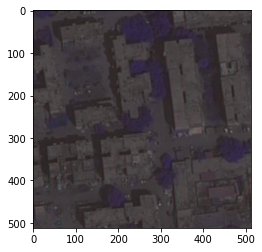

In [6]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
#from google.colab.patches import  cv2_imshow

#img = cv2.imread(data_path/'train/0001TP_006690.png')
img = cv2.imread(str(data_path) + '/train/img-34-33.jpg')
print(img.shape)
plt.imshow(img)

In [7]:
mask = cv2.imread(str(data_path) + '/train_labels/mask-34-33.jpg',0)
# mask = cv2.cvtColor((mask).astype(np.uint8), cv2.COLOR_BGR2RGB)# If you want to get the same order as in the color mapping of CAMVID, use the cv converted
mask.shape

(512, 512)

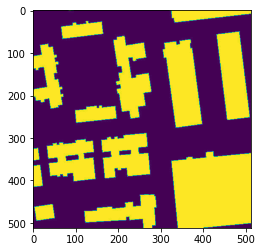

In [8]:
plt.imshow(mask)

# Dataloaders

In [9]:
def show_batch(generator, batch_number= 0):
  '''
  Helper function to show generated batch from `DataGenerator` class
  You expected to see some images with corresponding ID and masks
  args:-
    generator: Data generator contains the labels and imgs.
    batch_number: Number that in range of the number of batches of the data generator    
  '''
  print("The number of batches for this data = ", len(generator))
  
  batch = generator.__getitem__(batch_number)
  masks = batch[1]
  imgs = batch[0]

  w=10
  h=10
  fig=plt.figure(figsize=(25, 25))
  columns = 2
  rows = 2
  for i in range(1, columns*rows):
    img = imgs[i]

    mask = masks[i]
    mask = np.squeeze(mask, axis = 2)

    fig.add_subplot(rows, columns, i)
    plt.title(i, fontsize = 10)
    plt.imshow(img)
    plt.imshow(mask)
  plt.show()

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_path, data_type, batch_size=32,
                 img_size=(512,512), shuffle=True, n_channels = 3):
        self.data_path = data_path
        self.data_type = data_type
        self.batch_size = batch_size 
        self.img_size = img_size 
        self.n_channels = n_channels 
        self.shuffle = shuffle
        self.data_list = os.listdir(os.path.join(self.data_path,self.data_type))
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        #Generate indexes of the batch    
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]    
    
        #Find the list of images
        list_IDs_batch = [self.data_list[k] for k in indexes]

        imgs, masks = self.__data_generation(list_IDs_batch)

        return imgs, masks
    
    def __len__(self):
        return int(np.floor(len(self.data_list) / self.batch_size))
    
    def __data_generation(self, list_ID_batch):
        imgs = np.empty((self.batch_size, *self.img_size, self.n_channels))
        masks = np.empty((self.batch_size, *self.img_size, 1))

        for i, ID in enumerate(list_ID_batch):
            imgs[i]= self.get_img(ID, self.img_size)
            masks[i,]= self.get_mask(ID, self.img_size)
        return imgs, masks

    def get_img(self, img_id, img_size):
        image = cv2.imread(os.path.join(os.path.join(self.data_path,self.data_type),img_id))
        img = cv2.resize(image, img_size, cv2.INTER_LINEAR)
        return img/255.

    def get_mask(self,img_id, mask_size):
        img_id = img_id.split('-')
        mask_id = "mask-"+str(img_id[1])+"-"+str(img_id[2])
        mask = cv2.imread(os.path.join(os.path.join(self.data_path,self.data_type+"_labels"),mask_id),0)
        mask = cv2.resize(mask, mask_size, cv2.INTER_LINEAR)
        _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
        mask = np.expand_dims(mask, axis=2)
        return mask/255.

In [11]:
training_loader = DataGenerator(data_path, "train", batch_size=4, img_size=(512,512))

The number of batches for this data =  4


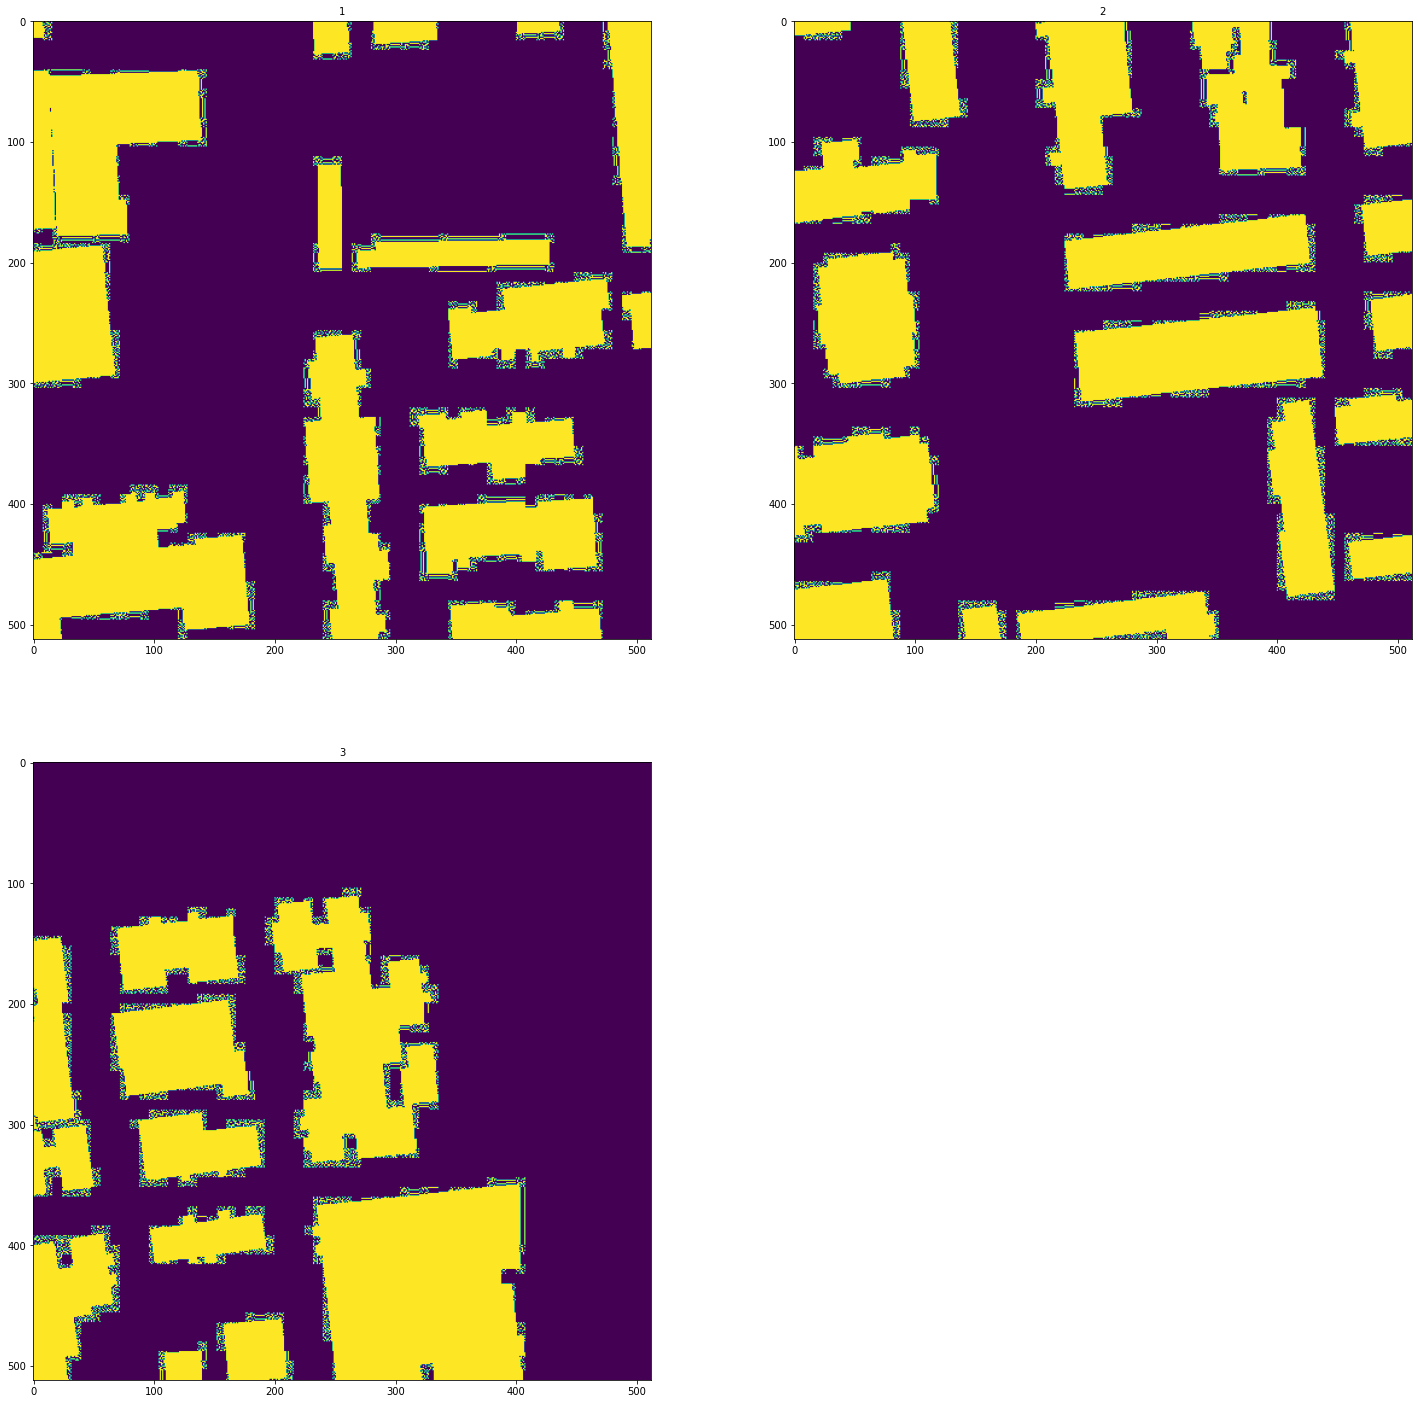

In [12]:
show_batch(training_loader, 1)

# U-Net Architecture

In [13]:
import numpy as np 
import os
#import skimage.io as io
import tensorflow as tf
#import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(input_size = (512,512,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    x = UpSampling2D(size = (2,2))(drop5)
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    output_layer = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs,output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.summary()
    return model



In [14]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [15]:
#data loaders 
training_loader = DataGenerator(data_path, "train", batch_size=4, img_size=(512,512))

validation_loader = DataGenerator(data_path, "val", batch_size=4, img_size=(512,512))

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit_generator(training_loader,
                    validation_data=validation_loader,
                    epochs=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/2
4/4 [==============================] - 51s 4s/step - loss: 7.4039 - accuracy: 0.3481
Epoch 2/2
4/4 [==============================] - 17s 4s/step - loss: 0.6620 - accuracy: 0.7276
